# Segmenation data: Potsdam

## Setup

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import argparse
import itertools
import os, sys
import pickle, shutil
from datetime import datetime
from pathlib import Path
from easydict import EasyDict as edict

import PIL, cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import torch
import torchvision.transforms as tvt

import IIC.archs as archs
from IIC.utils.cluster.general import config_to_str, get_opt, update_lr, nice
from IIC.utils.cluster.transforms import sobel_process
from IIC.utils.segmentation.segmentation_eval import segmentation_eval
from IIC.utils.segmentation.IID_losses import (IID_segmentation_loss, 
                                               IID_segmentation_loss_uncollapsed)
from IIC.utils.segmentation.data import segmentation_create_dataloaders
from IIC.utils.segmentation.general import set_segmentation_input_channels
from IIC.datasets.segmentation.potsdam import Potsdam

In [5]:
def _cp(src, dst):
    assert src.is_file()
    shutil.copy(src, dst)
    
Path.cp = _cp
Path.ls = lambda o: list(o.iterdir())

## Config

`Config` holds all sorts of user-specified information that will be used throughout the training process.

In [6]:
def get_default_config():
    return edict(
        model_ind=482,                       # type=int, required=True
        arch='SegmentationNet10a',           # type=str, required=True
        opt='Adam',   
        mode='IID+',  
        dataset='Potsdam',                   # type=str, required=True
        dataset_root='/scratch/local/ssd/xuji/POTSDAM',  # type=str, required=True
        use_coarse_labels=False,  # default=False, action="store_true")  # COCO, Potsdam
        fine_to_coarse_dict=(
            "/users/xuji/iid/iid_private/code/datasets"
            "/segmentation/util/out/fine_to_coarse_dict.pickle"),
        include_things_labels=False,
        incl_animal_things=False, 
        coco_164k_curated_version=-1,
        gt_k=3,                   # type=int, required=True
        output_k=9,               # type=int, required=True
        lamb=1.0,  
        lr=0.01,
        lr_schedule=[],
        lr_mult=.1,
        use_uncollapsed_loss=False,
        mask_input=False,
        num_epochs=1000,
        batch_sz=75, # type=int, required=True  # num pairs
        num_dataloaders=3,
        num_sub_heads=5,
        out_root="iid_private",
        restart=False,
        save_freq=5,
        test_code=False,
        batchnorm_track=False,
        # data transforms
        no_sobel=False,
        include_rgb=False,
        pre_scale_all=False,
        pre_scale_factor=.5,
        use_random_scale=False,
        scale_min=6., 
        scale_max=1.4,
        input_sz=161,
        # transforms we learn invariance to
        jitter_brightness=.4,
        jitter_contrast=.4,
        jitter_saturation=0.4,
        jitter_hue=0.125,
        flip_p=0.5,
        use_random_affine=False,
        aff_min_rot=-30., # degrees
        aff_max_rot=30.,  # degrees
        aff_min_shear=-10.,  # degrees
        aff_max_shear=10.,  # degrees
        aff_min_scale=0.8,
        aff_max_scale=1.2,

    # local spatial invariance. Dense means done convolutionally. Sparse means done
    #  once in data augmentation phase. These are not mutually exclusive
        half_T_side_dense=0,
        half_T_side_sparse_min=0,
        half_T_side_sparse_max=0)

In this notebook the data processing for the Potsdam dataset is looked at in detail. 

The following run taken from `examples/commands.txt` for a semi-supervised over-clustering segmentation of the Potsdam-3 dataset will be looked at here.

```
Potsdam-3 (482)
export CUDA_VISIBLE_DEVICES=2,3 && nohup python -m code.scripts.segmentation.segmentation --mode IID+ --dataset Potsdam --dataset_root /scratch/local/ssd/xuji/POTSDAM --model_ind 482 --arch SegmentationNet10a --num_epochs 4800 --lr 0.00001 --lamb 1.0 --num_sub_heads 1 --batch_sz 75 --num_dataloaders 1 --use_coarse_labels --output_k 9 --gt_k 3 --input_sz 200 --half_T_side_sparse_min 0 --half_T_side_sparse_max 0 --half_T_side_dense 10 --include_rgb --no_sobel --jitter_brightness 0.1 --jitter_contrast 0.1 --jitter_saturation 0.1 --jitter_hue 0.1 --use_uncollapsed_loss --batchnorm_track > sh13_gpu23_m482_r1.out &
```

Set the parameters values according to the command given above.

In [7]:
config = get_default_config()

In [8]:
config.mode = 'IID+'
config.dataset = 'Potsdam'
config.dataset_root = '/Users/jack/git_repos/IIC/datasets/POTSDAM/'
config.model_ind = 482
config.arch = 'SegmentationNet10a'
config.num_epochs = 4800
config.lr = 0.00001
config.lamb = 1.0
config.num_sub_heads = 1
config.batch_sz = 32
config.num_dataloaders = 1
config.use_coarse_labels = True
config.output_k = 9 
config.gt_k = 3 
config.input_sz = 200
config.half_T_side_sparse_min = 0 
config.half_T_side_sparse_max = 0 
config.half_T_side_dense = 10
config.include_rgb = True
config.no_sobel = True
config.jitter_brightness = 0.1 
config.jitter_contrast = 0.1 
config.jitter_saturation = 0.1 
config.jitter_hue = 0.1
config.use_uncollapsed_loss = True
config.batchnorm_track = True

To complete the configuration (applicable to all segmentation runs):

In [87]:
config.out_dir = os.path.join(config.out_root, str(config.model_ind))
config.dataloader_batch_sz = int(config.batch_sz / config.num_dataloaders)
assert (config.mode == "IID+")
assert (config.output_k >= config.gt_k)
assert (not (config.no_sobel and (not config.include_rgb)))
config.eval_mode = "orig"
config.use_doersch_datasets = False
set_segmentation_input_channels(config)

if not os.path.exists(config.out_dir):
    os.makedirs(config.out_dir)
    
if config.restart:
    config_name = "config.pickle"
    dict_name = "latest.pytorch"

    given_config = config
    reloaded_config_path = os.path.join(given_config.out_dir, config_name)
    print("Loading restarting config from: %s" % reloaded_config_path)
    with open(reloaded_config_path, "rb") as config_f:
        config = pickle.load(config_f)
    assert (config.model_ind == given_config.model_ind)
    config.restart = True

    # copy over new num_epochs and lr schedule
    config.num_epochs = given_config.num_epochs
    config.lr_schedule = given_config.lr_schedule
else:
    print("Given config: %s" % config_to_str(config))

Given config: Config: -----
model_ind: 482
arch: SegmentationNet10a
opt: Adam
mode: IID+
dataset: Potsdam
dataset_root: /Users/jack/git_repos/IIC/datasets/POTSDAM/
use_coarse_labels: True
fine_to_coarse_dict: /users/xuji/iid/iid_private/code/datasets/segmentation/util/out/fine_to_coarse_dict.pickle
include_things_labels: False
incl_animal_things: False
coco_164k_curated_version: -1
gt_k: 3
output_k: 9
lamb: 1.0
lr: 1e-05
lr_schedule: []
lr_mult: 0.1
use_uncollapsed_loss: True
mask_input: False
num_epochs: 4800
batch_sz: 32
num_dataloaders: 1
num_sub_heads: 1
out_root: iid_private
restart: False
save_freq: 5
test_code: False
batchnorm_track: True
no_sobel: True
include_rgb: True
pre_scale_all: False
pre_scale_factor: 0.5
use_random_scale: False
scale_min: 6.0
scale_max: 1.4
input_sz: 200
jitter_brightness: 0.1
jitter_contrast: 0.1
jitter_saturation: 0.1
jitter_hue: 0.1
flip_p: 0.5
use_random_affine: False
aff_min_rot: -30.0
aff_max_rot: 30.0
aff_min_shear: -10.0
aff_max_shear: 10.0
aff_

# Dataset

## `_Potsdam.__init__`

`dataset_root` is the directory that contains everything to do with the Potsdam dataset: the images, image ids, and labels, etc.

In [10]:
Path(config.dataset_root).ls()

[PosixPath('/Users/jack/git_repos/IIC/datasets/POTSDAM/debugged.out'),
 PosixPath('/Users/jack/git_repos/IIC/datasets/POTSDAM/gt'),
 PosixPath('/Users/jack/git_repos/IIC/datasets/POTSDAM/imgs'),
 PosixPath('/Users/jack/git_repos/IIC/datasets/POTSDAM/labelled_train.txt'),
 PosixPath('/Users/jack/git_repos/IIC/datasets/POTSDAM/unlabelled_train.txt'),
 PosixPath('/Users/jack/git_repos/IIC/datasets/POTSDAM/labelled_test.txt')]

The dataset has three subsets, each of which has a corresponding text file containing the ids of the images in the subset.  For example, `labelled_train.txt` contains the image ids for the subset `'labelled_train'`. 

In [25]:
split, purpose, preload = 'labelled_test', 'test', False

In [26]:
root = Path(config.dataset_root)
single_mode = hasattr(config, 'single_mode') and config.single_mode

In [27]:
assert (root/'debugged.out').exists()

Define a set of transformations of brightness, contrast, saturation, and hue.  As will be seen below, this is only applied to the images when `purpose=train`.

In [28]:
jitter_tf = tvt.ColorJitter(brightness=config.jitter_brightness,
                            contrast=config.jitter_contrast,
                            saturation=config.jitter_saturation,
                            hue=config.jitter_hue)

In [29]:
files, images, labels = [], [], []

In [30]:
cv2.setNumThreads(nthreads=0)

## `_Potsdam.set_files()`

Get the image ids of the specified subset from its text file and store them in a list.

In [17]:
file_list = root/f'{split}.txt'
file_list = tuple(open(file_list, 'r'))
file_list = [id_.rstrip() for id_ in file_list]
file_list[:4]

['3079', '2269', '5296', '5034']

## `_Potsdam.load_data()`

For an image id, load its image from disk, and load its label if it is available.  Both the image and the label are saved in `.mat` files.

In [36]:
index = 189

In [37]:
image_id = file_list[index]
image_id

'939'

In [38]:
image_path = root/'imgs'/f'{image_id}.mat'
label_path = root/'gt'/f'{image_id}.mat'

In [39]:
image = sio.loadmat(image_path)['img']
assert image.dtype==np.uint8
image.shape

(200, 200, 4)

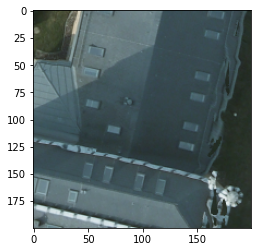

In [40]:
plt.imshow(image[...,:3]);

In [41]:
assert label_path.exists()
label = sio.loadmat(label_path)['gt']
assert label.dtype==np.int32
label.shape

(200, 200)

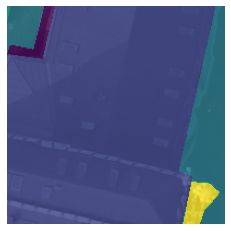

In [42]:
_, ax = plt.subplots()
ax.imshow(image[...,:3])
ax.imshow(label, alpha=.8)
ax.axis('off');

## `_Potsdam._prepare_train()`

Here's how the loaded image is processed if `purpose=train` (if it's used for training the model).

In [35]:
from IIC.utils.segmentation.transforms import pad_and_or_crop
from IIC.utils.segmentation.render import render

In [148]:
# This is actually not required for the current config.
image = image.astype(np.int32) 

In [28]:
assert config.pre_scale_all==False

In [29]:
assert config.use_random_scale==False

In [30]:
config.input_sz, image.shape

(200, (200, 200, 4))

`pad_and_or_crop` doesn't seem to have an effect here because the input size is equal to the image size.

In [31]:
image, coords = pad_and_or_crop(image, config.input_sz, mode='random')

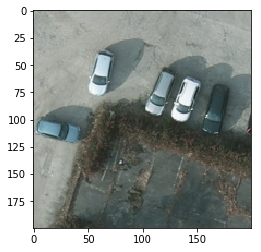

In [32]:
plt.imshow(image[...,:3])

In [33]:
img = image[...,:3]
img_ir = image[...,3]

In [34]:
img1 = PIL.Image.fromarray(img.astype(np.uint8))
img2 = jitter_tf(img1)

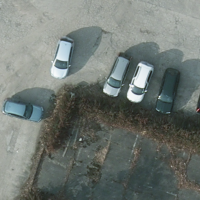

In [35]:
img1

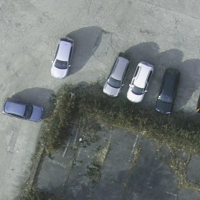

In [36]:
img2

In [37]:
img1, img2 = (np.array(img) for img in [img1, img2])

In [38]:
assert config.no_sobel==True

In [39]:
img1, img2, img_ir = (img.astype(np.float32) / 255 
                      for img in [img1, img2, img_ir])

In [40]:
img1, img2 = (np.concatenate([img, img_ir[...,None]], axis=2)
              for img in [img1, img2])

In [41]:
img1, img2 = (torch.from_numpy(img).permute(2, 0, 1)
              for img in [img1, img2])

In [42]:
assert config.use_random_affine==False

In [43]:
affine2_to_1 = torch.zeros((2, 3), dtype=torch.float32)
affine2_to_1[0,0] = 1
affine2_to_1[1,1] = 1
affine2_to_1

tensor([[1., 0., 0.],
        [0., 1., 0.]])

In [44]:
if np.random.rand() > config.flip_p:
    img2 = torch.flip(img2, dims=[2])
    affine2_to_1[0,:] *= -1.

In [45]:
affine2_to_1

tensor([[-1., -0., -0.],
        [ 0.,  1.,  0.]])

In [46]:
mask_img1 = torch.ones((config.input_sz, config.input_sz)).to(torch.uint8)

`_prepare_train` returns `img1`, `img2`, `affine2_to_1`, and `mask_img1`.  Below, they're rendered, saved to disk, and displayed.

In [47]:
render(img1, mode='image', name=f'train_data_img1_{index}')
render(img2, mode='image', name=f'train_data_img2_{index}')
render(affine2_to_1, mode='matrix', name=f'train_data_affine2to1_{index}')
render(mask_img1, mode='mask', name=f'train_data_mask_{index}')

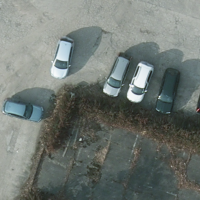

In [48]:
PIL.Image.open('train_data_img1_189.png')

`img2` contains some color jitter and is flipped left-right.

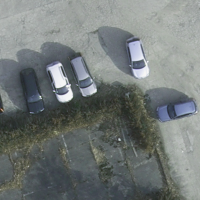

In [49]:
PIL.Image.open('train_data_img2_189.png')

The `-1` indicates that `img2` has been flipped left to right.

In [50]:
open('train_data_affine2to1_189.txt', 'r').read()

'[[-1. -0. -0.]\n [ 0.  1.  0.]]'

`mask_img1` is above created as a tensor of 1s of type `uint8`. 

In [51]:
np.array(PIL.Image.open('train_data_mask_189.png'))

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

## `_Potsdam._prepare_test()`

Here's how an image loaded from its `.mat` file is processed if the purpose is for test or for validation (`purpose='test'`).

In [43]:
image.shape, label.shape, index

((200, 200, 4), (200, 200), 189)

For test and validation, there should be a label, in order to evaluate the prediction.

In [45]:
assert (label is not None)

In [46]:
assert (image.shape[:2]==label.shape)

In [47]:
image = image.astype(np.float32)
label = label.astype(np.int32)

In [53]:
#For this particular example `pre_scale_all=False`.
assert config.pre_scale_all==False

In [50]:
image, _ = pad_and_or_crop(image, config.input_sz, mode='centre')
label, _ = pad_and_or_crop(label, config.input_sz, mode='centre')

In [51]:
image.shape, label.shape

((200, 200, 4), (200, 200))

The RGB channels are separated from the IR channel before undergoing sobel processing, if it's specified (in this particular example, it's not).

In [52]:
img_ir = image[...,3]
img = image[...,:3]

In [54]:
#For this particular example, `no_sobel` is `True`.
assert config.no_sobel==True

In [55]:
img, img_ir = (o.astype(np.float32) / 255. for o in [img, img_ir])

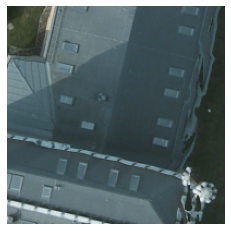

In [57]:
plt.imshow(img); plt.axis('off');

In [58]:
img = np.concatenate([img, img_ir[...,None]], axis=2)

In [59]:
img.shape

(200, 200, 4)

In [60]:
img = torch.from_numpy(img).permute(2, 0, 1)

In [61]:
label.shape

(200, 200)

Optionally render the image, or the label.  At the moment, rendering `label` with `mode='label'` raises an error.

In [193]:
# render(label, mode='mask', name=f'test_data_label_pre_{index}')

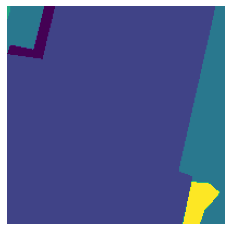

In [62]:
plt.imshow(label); plt.axis('off');

To have only 3 instead of 6 segmentation classes, *roads* and *cars* are merged, *buildings* and *clutter* are merged, and *vegetation* and *trees* are merged into one.

In [66]:
if config.use_coarse_labels:
    _fine_to_coarse_dict = {0:0, 4:0,  # roads and cars
                            1:1, 5:1,  # buildings and clutter
                            2:2, 3:2}  # vegetation and trees
    new_label_map = np.zeros(label.shape, dtype=label.dtype)
    for c in range(6):
        new_label_map[label==c] = _fine_to_coarse_dict[c]

`label` after the number of segmentation classes have been reduced to 3.

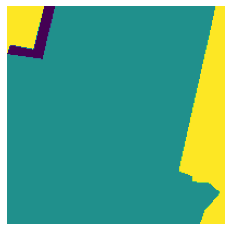

In [67]:
plt.imshow(new_label_map); plt.axis('off');

As with training examples, `mask` is an array of 1s.

In [203]:
mask = torch.ones(config.input_sz, config.input_sz).to(torch.uint8)

In [206]:
# render(img, mode='image', name=f'test_data_img_{index}')
# render(new_label_map, mode='mask', name=f'test_data_label_post_{index}')
# render(mask, mode='mask', name=f'test_data_mask_{index}')

## `Potsdam._check_gt_k()`

`config.gt_k` is the number of segmentation classes.  It can only be either 3 or 6.  

In [68]:
if config.use_coarse_labels:
    assert config.gt_k==3
else:
    assert config.gt_k==6

## `Potsdam.__init__()`

The mapping for the merging of segmentation classes is defined here.

In [69]:
_fine_to_coarse_dict = {0:0, 4:0,  # roads and cars
                        1:1, 5:1,  # buildings and clutter
                        2:2, 3:2}  # vegetation and trees

# Dataloaders

## `segmentation_create_datalosders()`

`utils.segmentation.data.segmentation_create_dataloaders()`.

In [31]:
[n.name for n in root.ls() if n.name.endswith('.txt')]

['labelled_train.txt', 'unlabelled_train.txt', 'labelled_test.txt']

In this example, `mode` is set to `IID+`, for 'semi-supervised overclustering' (`IID` is for 'fully unsupervised'). `dataset` is set to `Potsdam`.

Dataset splits for this particular training example is as follows.

In [66]:
config.mode, config.dataset

('IID+', 'Potsdam')

For this mode and dataset, the following dataset splits are used:

In [70]:
config.train_partitions = ['unlabelled_train', 'labelled_train']
config.mapping_assignment_partitions = ['labelled_train']
config.mapping_test_partitions = ['labelled_test']

## Training dataloader(s)

Training dataloaders are created using `utils.segmentation.data._create_dataloaders()`. This function can return more than one dataloader, but in this example, only one is used. 

In [71]:
do_shuffle = (config.num_dataloaders==1)

In [72]:
config.train_partitions

['unlabelled_train', 'labelled_train']

Create datasets for the splits in `config.train_partitions`.

In [73]:
unlabelled_train_imgs = Potsdam(
    config=config, split='unlabelled_train', purpose='train')

labelled_train_imgs = Potsdam(
    config=config, split='labelled_train', purpose='train')

Number of unlabelled and labelled examples:

In [75]:
len(unlabelled_train_imgs), len(labelled_train_imgs)

(3150, 4545)

Not doing `doersch` here.

In [88]:
assert config.use_doersch_datasets==False

Concatenate the datasets of the splits from above.

In [76]:
from torch.utils.data import ConcatDataset

In [77]:
train_imgs = ConcatDataset([unlabelled_train_imgs, labelled_train_imgs])

In [78]:
len(train_imgs)

7695

Create the usual `torch` dataloader with the dataset from the concatenation.

In [79]:
train_dataloader = torch.utils.data.DataLoader(
    train_imgs, batch_size=config.batch_sz, shuffle=do_shuffle,
    num_workers=0, drop_last=False)

In [80]:
dataloaders = []

In [81]:
dataloaders.append(train_dataloader)

In [82]:
len(dataloaders[0])

241

## Test dataloader

For `purpose='test'` splits, the dataloaders are created with `utils.segmentation.data._create_mapping_loader()`.  

Here, it's illustrated for the `labelled_test` split.

In [92]:
config.mapping_test_partitions

['labelled_test']

In [93]:
labelled_test_imgs = Potsdam(
    config=config, split='labelled_test', purpose='test')

In [94]:
assert config.use_doersch_datasets==False

In [95]:
test_imgs = ConcatDataset([labelled_test_imgs])

In [97]:
test_dataloader = torch.utils.data.DataLoader(
    test_imgs, batch_size=config.batch_sz, shuffle=False, 
    num_workers=0, drop_last=False)

Load and look at a batch.

In [98]:
test_batch = next(iter(test_dataloader))

In [99]:
test_batch[0].shape, test_batch[1].shape, test_batch[2].shape

(torch.Size([32, 4, 200, 200]),
 torch.Size([32, 200, 200]),
 torch.Size([32, 200, 200]))

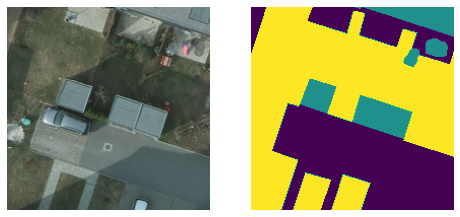

In [114]:
idx = 23
img = test_batch[0][idx].permute(1, 2, 0).numpy()[...,:3]
label = test_batch[1][idx].numpy()

_, axs = plt.subplots(ncols=2, figsize=(8, 4))
for ax, im in zip(axs, [img, label]):
    ax.imshow(im)
    ax.axis('off');

# Reference

- [Invariant Information Clustering for Unsupervised Image Classification and Segmentation](https://arxiv.org/pdf/1807.06653.pdf)